# Introduction to Machine Learning (CSCI-UA.473)

## Homework 3: Implementing kernelized support vector machines and backpropagation algorithm for a multi-layer perceptron

### Due: November 3rd, 2021 at 11:59PM
### Name: Jerry Jia
### Email: tj1043@nyu.edu

**Please submit two files as part of your homework: the solved Python notebook and a pdf version of the final notebook. Create a zip file with these two files and name it as <netid>_hw3.zip**

Please DO NOT change the position of any cell in this assignment. If the notebook hangs sometimes before the cell that defines SVM class, please restart it.

You will need the following packages below to do the homework.  Please DO NOT import any other packages.
### WARNING!
Some parts below (especially with cross-validation) could take around ~10 - 15 min.  If it takes much longer than this, then you likely have an error. To keep track of the computation I would encourage you to think ways of inserting print statements at appropriate places in the code. 

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from scipy.optimize import minimize
import matplotlib.pyplot as plt

## Loading and spliting the data
For this assignment, we utilized the Iris dataset from sklearn library. We will use only the first two input variables of the data set as our input features. We will convert this into a binary classification task by ignoring class 0 and only working with classes 1 and 2. Lastly, we will split the data set into two sets, such that the training_set:test_set ratio is 70:30. 
* `X_train` and `y_train` are `features` and `labels` for training, while `X_test` and `y_test` are for testing.

In [16]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

X = X[y != 0, :2] # Only use the first two features.
y = y[y != 0]     # Ignore the first class.
y[y==2] = -1      # Change class label to -1 for SVM.

n_sample = len(X) # Total number of data points.

# Split data into training and testing sets.
#np.random.seed(0)
order = np.random.permutation(n_sample)
X = X[order]
y = y[order].astype(np.float)

X_train = X[:int(.7 * n_sample)]
y_train = y[:int(.7 * n_sample)]
X_test = X[int(.7 * n_sample):]
y_test = y[int(.7 * n_sample):]

In [17]:
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (70, 2)
y_train: (70,)
X_test: (30, 2)
y_test: (30,)


## Question P1. Kernel SVM (50 Points Total)

In this part of the assignment you will implement a kernelized version of the Support Vector Machines (SVMs). Below is a very brief overview of the kernel trick used in SVMs. 

Recall that for linear SVM the dual problem is given by 

$$
\begin{align*}
\max_{\alpha} W(\alpha) &= \sum_{i=1}^n \alpha_i - \frac{1}{2}\sum_{i=1}^{n}\sum_{j=1}^{n} y_i y_j \alpha_i \alpha_j \langle x_i, x_j\rangle \\
\text{s.t.} & \quad 0 \le \alpha_i \le C, \quad i = 1,\ldots,n \\
& \sum_{i=1}^n \alpha_i y_i = 0
\end{align*}$$

where $\alpha \in \mathbb{R}^n$ is a vector.  

If the data is not linearly separable, we can project the input features $x_i$ into another potentially high-dimensional space denoted by $\phi(x_i)$. The dual formulation of SVM in that space now becomes: 
$$
\begin{align*}
\max_{\alpha} W(\alpha) &= \sum_{i=1}^n \alpha_i - \frac{1}{2}\sum_{i=1}^{n}\sum_{j=1}^{n} y_i y_j \alpha_i \alpha_j \langle \phi(x_i), \phi(x_j)\rangle \\
\text{s.t.} & \quad 0 \le \alpha_i \le C, \quad i = 1,\ldots,n \\
& \sum_{i=1}^n \alpha_i y_i = 0
\end{align*}
$$
Since $\phi(x_i)$ could potentially be very high dimensional, computing the dot product $\langle \phi(x_i), \phi(x_j)\rangle$ over the course of training and inference can be very expensive. In order to avoid the explicit computation of this dot product, we can make use of the ``kernel trick``, which says that the dot product in the high-dimensional space for certain feature maps $\phi$ is equivalent to computing the value of the kernel in the original low-dimensional input space. That is: 

$$
K(x_i, x_j) = \langle \phi(x_i), \phi(x_j)\rangle
$$

Thus the dual formulation of the SVM now becomes: 
$$
\begin{align*}
\max_{\alpha} W(\alpha) &= \sum_{i=1}^n \alpha_i - \frac{1}{2}\sum_{i=1}^{n}\sum_{j=1}^{n} y_i y_j \alpha_i \alpha_j K(x_i, x_j) \\
\text{s.t.} & \quad 0 \le \alpha_i \le C, \quad i = 1,\ldots,n \\
& \sum_{i=1}^n \alpha_i y_i = 0
\end{align*}$$



### P1.a: Implement the kernel functions (10 Points -- 2.5 Points Each)
You will implement the following four kernels: 

1. `linear`: $k(x_i,x_j)=x_i^T x_j$ (this is effectively what you did in the previous homework)

2. `poly`: $k(x_i,x_j)=\left(x_i^T x_j + 1\right)^2$

3. `rbf`: $k(x_i,x_j) = \exp\left( -\frac{1}{2}\|x_i - x_j\|^2 \right)$

4. `laplace`: $k(x_i,x_j)=\exp\left(-\frac{1}{2}\left\| x_i - x_j \right\| \right)$

Complete the function below by implementing the kernel function for each case.

In [18]:
def kernel_product(x1, x2, kernel = 'linear'):
    """
    Compute the kernel product k(x1,x2) for different choices of the kernel k.
    
    Input:
        x1: np.ndarray(p,), the first vector
        x2: np.ndarray(p,), the second vector
        kernel: str, a string which is the name of the kernel, must match one of the options below exactly
        linear, poly, rbf, laplace
    
    Return:
        k: float, the value of the kernel k(x1, x2)
    """

    ##TODO-start##
    if kernel == 'linear':
        k = x1 @ x2
        return k
    elif kernel == 'poly':
        k = (x1 @ x2 + 1) ** 2
        return k
    elif kernel == 'rbf':
        k = np.exp(-1/2 * np.linalg.norm(x1 - x2) ** 2)
        return k
    elif kernel == 'laplace':
        k = np.exp(-1 / 2 * np.linalg.norm(x1 - x2))
        return k
    ## TODO-end##
    else:
        print("Invalid kernel: {:s}".format(kernel))

The next cell is just a helper method. You do not need to implement anything in it.

In [19]:
def kernel_product_matrix(X, kernel='linear'):
    """
    Compute the inner product matrix of two vectors.
    
    Input:
        X: np.ndarray(n,p), data matrix with n data points (each row) and p features
        kernel: str, a string which is the name of the kernel, must match one of the options below exactly
        linear, poly, rbf, laplace
    
    Return:
        K: np.ndarray(n,n), each entry is the kernel product of the corresponding pair of vectors
    """
    n = len(X)
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            K[i, j] = kernel_product(X[i], X[j], kernel)
            K[j, i] = K[
                i, j]  # Matrix is symmetric so we can cut computation in half.
    return K

### P1.b: Implement the kernel SVM (20 Points)

Now you will extend your SVM implementation from the previous homework by including kernels.  Finish the SVM class below by filling in the missing lines of code. Similar to the previous homework, you will need to do 3 things: 

1. Implement the objective function for the dual problem for minimization.  Note that we actually maximize the dual objective function, but in order to use the `minimize()` function from Sci-Py you will need to take the negative.

2. Compute the bias.  Use your implementation from the previous homework for guidance and think carefully about what needs to change.

3. Implement the `predict()` function.

In [54]:
class SVM:


    def __init__(self, C = 1, kernel = 'linear'):
        """
        Initialize the SVM model.
        
        Input:
            C: float, the regularization constant for SVM.
            kernel: str, a string which is the name of the kernel, must match one of the options below exactly
            linear, poly, rbf, laplace
        
        Return:
            None
        """
        assert C >= 0
        self.C = C
        self.kernel = kernel
        # The following variables are set after fit() is called.
        self.X_train = None
        self.y_train = None
        self.bias  = None
        self.alpha = None

    def objective_function(self, a, X, y):
        """
        The objective function of the dual problem W.

        Input:
            a: np.ndarray(n,), the parameter alpha we want to optimize
            X: np.ndarray(n, p), the matrix of training data features
            y: np.ndarray (n,), the vector of training data labels, must be either +1 or -1.

        Return:
            W: float, value of the objective function.
        """
        # s = np.diag(y) @ np.diag(a) @ kernel_product_matrix(X, self.kernel)
        # W = np.sum(a) - 0.5 * np.sum(s)
        n = X.shape[0]
        s = 0
        M = kernel_product_matrix(X, self.kernel)
        for i in range(n):
            for j in range(n):
                s += y[i] * y[j] * a[i] * a[j] * M[i, j]
        return np.sum(a) - 0.5 * s
        # W = np.sum(a) - 0.5 * np.sum(
        #     np.diag(y) @ np.diag(a) @ kernel_product_matrix(X, self.kernel))
        # return W
    # def objective_function_vectorized(self, a, X, y):
    #     s = a.T @ np.diag(y) @ kernel_product_matrix(
    #         X, self.kernel) @ np.diag(y) @ a
    #     return 0.5 * a.T @ np.diag(y) @ kernel_product_matrix(
    #         X, self.kernel) @ np.diag(y) @ a - np.sum(a)

    def fit(self, X_train, y_train):
        """
        Computes the parameters alpha and bias that determine the maximum-margin decision boundary for SVM.
        bias will be a float, alpha is a np.ndarray(n,) vector of the dual variables.
    
        Input:
            X_train: np.ndarray(n,p), matrix of training data features
            y_train: np.ndarray(n, ), vector of training data labels
        
        Return:
            None
        """
        # Save the training data.
        self.X_train = X_train
        self.y_train = y_train
        # Number of training points and dimension.
        n, p = X_train.shape

        # Get the negative objective function to change maximization to minimization.
        ##TODO-start##
        # W = lambda a: -self.objective_function_vectorized(a, self.X_train, self.y_train)
        W = lambda a: 0.5 * (
            a.T @ np.diag(y_train) @ kernel_product_matrix(
                X_train, self.kernel) @ np.diag(y_train) @ a) - np.sum(a)
        ##TODO-end##

        # Initialization and constraints for optimization.
        init_pt = np.zeros(n)
        bnds = tuple([(0, self.C) for i in range(n)])
        cons = ({'type': 'eq', 'fun': lambda x:  np.dot(x, y_train)})
        # Solve the dual problem for SVM.
        res = minimize(W, init_pt, method='SLSQP', bounds=bnds,
               constraints=cons)
        alpha = res.x
        self.alpha = alpha

        # # Compute the bias
        ##TODO-start##
        # def bias(a, X, y):
        #     y_pred = np.zeros(y.shape)
        #     for i in range(n):
        #         for j in range(n):
        #             y_pred[i] += a[j] * y[j] * kernel_product(
        #                 X[i], X[j], self.kernel)
        #     return np.sum(y - y_pred) / n

        # self.bias = bias(self.alpha, self.X_train, self.y_train)

        self.bias = np.mean(y_train - np.diag(alpha) @ np.diag(y_train) @ kernel_product_matrix(X_train, self.kernel))
        ##TODO-end##


    def predict(self, X_test):
        """
        Compute the predictions y_pred on the test set using only the support vectors.

        Input:
            X_test: np.ndarray(n,p), matrix of the test data

        Return:
            y_pred: np.ndarray(n,), vector of the predicted labels, either +1 or -1
        """
        ##TODO-start##
        n_train = self.X_train.shape[0]
        n_test = X_test.shape[0]
        # y_pred = np.ndarray(n_test)
        y_pred = np.zeros(n_test)

        for t in range(n_test):
            for i in range(n_train):
                y_pred[t] += self.y_train[i] * self.alpha[i] * kernel_product(
                    X_test[t], self.X_train[i], self.kernel)

        y_pred += self.bias
        y_pred[y_pred >= 0] = 1
        y_pred[y_pred < 0] = -1
        ##TODO-end##
        return y_pred

There is nothing to do in the next cell. It is just a helper function. 

In [21]:
def accuracy(y_pred, y_test):
    """
    Computes the accuracy on the test set given the class predictions.
    
    Input:
        y_pred: np.ndarray(n,), vector of predicted class labels
        y_test: np.ndarray(n,), vector of true class labels
    
    Output:
        float, accuracy of predictions
    """
    return np.mean(y_pred*y_test > 0) 

### Draw the decision boundaries of all kernels (nothing to do here)
The following is an illustration of decision boundaries for SVM with kernels. You do not need to do anything in the next cell.  It is only to check your work.

SVM with linear kernel, accuracy = 73.33%


/tmp/ipykernel_12568/1745940528.py:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)


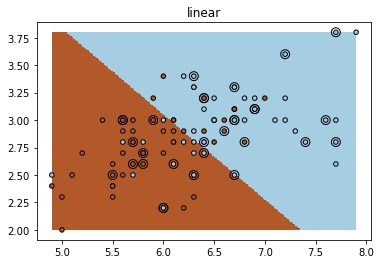

In [47]:
# kernel_list = ['linear', 'rbf', 'poly', 'laplace']
# kernel = 'poly'
kernel = 'linear'

model = SVM(C=10, kernel=kernel)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("SVM with {:s} kernel, accuracy = {:0.2f}%".format(
    kernel, 100 * accuracy(y_pred, y_test)))

plt.figure()
plt.clf()
plt.scatter(X[:, 0],
            X[:, 1],
            c=y,
            zorder=10,
            cmap=plt.cm.Paired,
            edgecolor='k',
            s=20)

# Circle out the test data
plt.scatter(X_test[:, 0],
            X_test[:, 1],
            s=80,
            facecolors='none',
            zorder=10,
            edgecolor='k')

plt.axis('tight')
x_min = X[:, 0].min()
x_max = X[:, 0].max()
y_min = X[:, 1].min()
y_max = X[:, 1].max()

XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
XXYY = np.c_[XX.ravel(), YY.ravel()]
Z = model.predict(XXYY)

# Put the result into a color plot
Z = Z.reshape(XX.shape)
plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
plt.title(kernel)

plt.show()

SVM with linear kernel, accuracy = 56.67%
SVM with rbf kernel, accuracy = 76.67%
SVM with poly kernel, accuracy = 43.33%
SVM with laplace kernel, accuracy = 66.67%


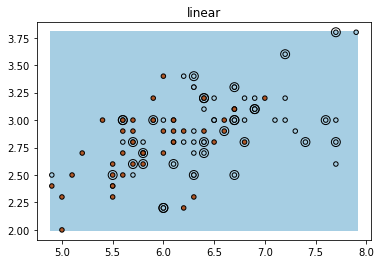

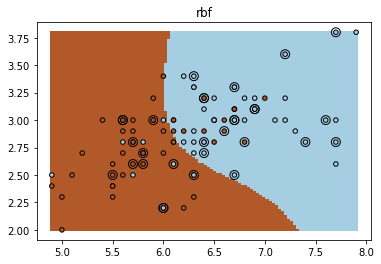

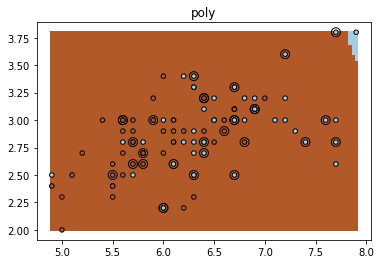

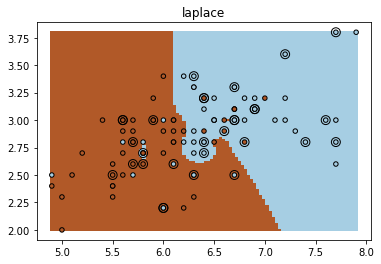

In [55]:
kernel_list = ['linear', 'rbf', 'poly', 'laplace']

for kernel in kernel_list:
    model = SVM(C=10, kernel=kernel)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("SVM with {:s} kernel, accuracy = {:0.2f}%".format(
        kernel, 100 * accuracy(y_pred, y_test)))

    plt.figure()
    plt.clf()
    plt.scatter(X[:, 0],
                X[:, 1],
                c=y,
                zorder=10,
                cmap=plt.cm.Paired,
                edgecolor='k',
                s=20)

    # Circle out the test data
    plt.scatter(X_test[:, 0],
                X_test[:, 1],
                s=80,
                facecolors='none',
                zorder=10,
                edgecolor='k')

    plt.axis('tight')
    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()

    XX, YY = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
    # XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    XXYY = np.c_[XX.ravel(), YY.ravel()]
    Z = model.predict(XXYY)

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired, shading='auto')
    plt.title(kernel)

plt.show()

### P1.c: Cross-validation to choose the regularization parameter $C$ (15 Points)

Complete the cross-validation function below.  The data has already been randomly arranged for you.  There are 4 things you will need to do for each fold.

1. Split the training data
2. Train the model
3. Get the predictions
4. Compute the accuracy

In [52]:
def cross_validation(model, X_train, y_train, folds = 5):
    """
    Perform k-fold cross-validation on model using the available training data.  You may assume that 
    the number of training data points is divisible by the number of folds.
    
    Input:
        model: SVM object, an instance of the SVM class, must have fit and predict implemented.
        X_train: np.ndarray(n,p), training data features
        y_train: np.ndarray(n,), training data labels
        folds: int, number of cross-validation folds to perform
    
    Output:
        acc: float, the mean accuracy from all cross-validation folds
        acc_results: np.ndarray(folds,), the accuracy results from each cross-validation fold
    """
    n = X_train.shape[0] # Number of available training data points.
    acc_results = np.zeros(folds) # Store the cross-validation results here.

    # Randomly permute the data.
    permutation = np.random.permutation(n)
    X_train = X_train[permutation, :]
    y_train = y_train[permutation]

    size = int(n / folds) # Size of each fold.
    for k in range(folds):
        # print("Fold {:d} / {:d} is running.".format(k, folds), end='\t')
        ##TODO-start##
        s1 = k * size
        s2 = (k + 1) * size
        # XX_val = X_train[s1:s2, :]
        # XX_train = np.concatenate((X_train[:s1], X_train[s2:]))
        # yy_val = y_train[s1:s2]
        # yy_train = np.concatenate((y_train[:s1], y_train[s2:]))
        # print(f's1={s1}, s2={s2}', end='\t')
        model.fit(np.concatenate((X_train[:s1], X_train[s2:])),
                  np.concatenate((y_train[:s1], y_train[s2:])))
        y_pred = model.predict(X_train[s1:s2, :])
        acc_results[k] = accuracy(y_pred, y_train[s1:s2])
        # print("Accuracy = {:0.2f}%".format(100*acc_results[k]))
        ##TODO-end##

    acc = np.mean(acc_results)
    return (acc, acc_results)

Run the next cell to check your work.  There is nothing you need to implement here.

In [53]:
C_list = [0.001, 0.01, 0.1, 0.5, 1, 5]

for c in C_list:
    print('Cross-validation for C = {:0.3f}'.format(c))
    model = SVM(C = c, kernel = 'rbf')
    acc, acc_results = cross_validation(model, X_train, y_train)
    print('Mean = {:0.2f}%'.format(100*acc))

Cross-validation for C = 0.001
Mean = 44.29%
Cross-validation for C = 0.010
Mean = 47.14%
Cross-validation for C = 0.100
Mean = 67.14%
Cross-validation for C = 0.500
Mean = 72.86%
Cross-validation for C = 1.000
Mean = 67.14%
Cross-validation for C = 5.000
Mean = 65.71%


### P1.d: Mean and standard deviation of cross-validation scores (5 Points)

Now use 10-fold cross-validation on two models: 1. SVM with RBF kernel and 2. SVM with the linear kernel.  Set the regularization parameter $C = 0.5$ for both models.  Print out the mean accuracy and the standard deviation of the accuracies from each fold using the numpy functions `np.mean()` and `np.std()`.  Format your results as percentages to two decimal places using Python's `format()` function for strings so that it is easy to read.  Make sure the values you are printing are clearly indicated.

In [50]:
##TODO-start##
print('Cross-validation for SVM with RBF kernel')
model = SVM(C = 0.5, kernel = 'rbf')
acc, acc_results = cross_validation(model, X_train, y_train, folds=10)
print('Mean = {:0.2f}%; Standard Deviation = {:0.2f}%'.format(100*acc, np.std(acc_results)))

print('Cross-validation for SVM with linear kernel')
model = SVM(C=0.5, kernel='linear')
acc, acc_results = cross_validation(model, X_train, y_train, folds=10)
print('Mean = {:0.2f}%; Standard Deviation = {:0.2f}%'.format(100 * acc, np.std(acc_results)))
##TODO-end##

Cross-validation for SVM with RBF kernel
Fold 0 / 10 is running.	Accuracy = 71.43%
Fold 1 / 10 is running.	Accuracy = 85.71%
Fold 2 / 10 is running.	Accuracy = 57.14%
Fold 3 / 10 is running.	Accuracy = 14.29%
Fold 4 / 10 is running.	Accuracy = 42.86%
Fold 5 / 10 is running.	Accuracy = 71.43%
Fold 6 / 10 is running.	Accuracy = 100.00%
Fold 7 / 10 is running.	Accuracy = 100.00%
Fold 8 / 10 is running.	Accuracy = 71.43%
Fold 9 / 10 is running.	Accuracy = 85.71%
Mean = 70.00%; Standard Deviation = 0.25%
Cross-validation for SVM with linear kernel
Fold 0 / 10 is running.	Accuracy = 42.86%
Fold 1 / 10 is running.	Accuracy = 85.71%
Fold 2 / 10 is running.	Accuracy = 71.43%
Fold 3 / 10 is running.	Accuracy = 85.71%
Fold 4 / 10 is running.	Accuracy = 57.14%
Fold 5 / 10 is running.	Accuracy = 42.86%
Fold 6 / 10 is running.	Accuracy = 71.43%
Fold 7 / 10 is running.	Accuracy = 57.14%
Fold 8 / 10 is running.	Accuracy = 100.00%
Fold 9 / 10 is running.	Accuracy = 57.14%
Mean = 67.14%; Standard Deviat

## Question P2. Multi-layer perceptron training using backpropagation (40 Points Total)

In this part of the homework you will implement a multi-layer perceptron model and train it using the backpropagation algorithm. 

Import the packages. Please do not import any other packages. 

In [2]:
import os
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import numpy as np
%matplotlib inline

### Loading and splitting the data
We will load and work with the half moons data set from sklearn and train a multi-layer perceptron to distinguish between the two classes

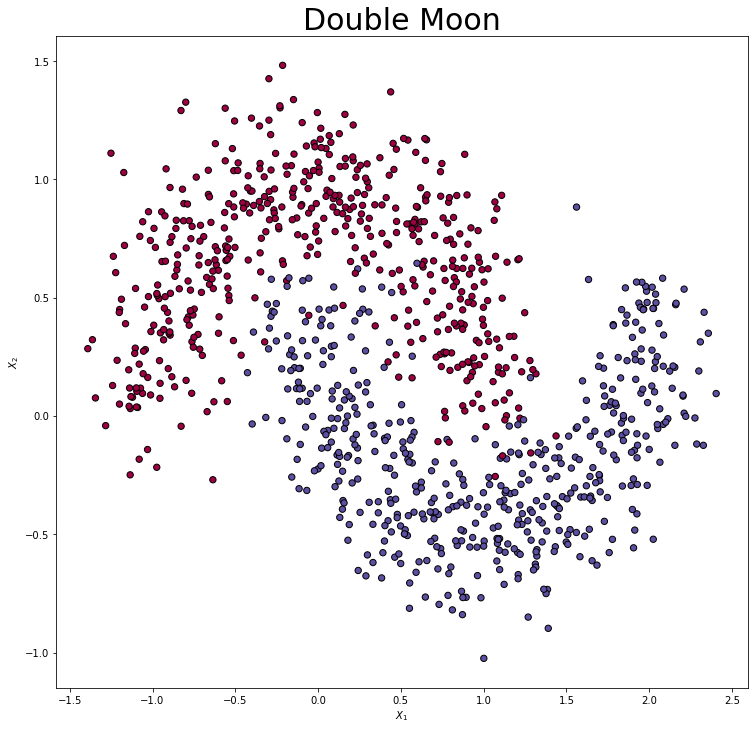

In [3]:
# number of samples in the data set
N_SAMPLES = 1000
# ratio between training and test sets
TEST_SIZE = 0.1

# Double moon dataset
X, y = make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=False):
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 1, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black')
    if(file_name):
        plt.savefig(file_name)
        plt.close()
        
make_plot(X, y, "Double Moon")

### P2.a: Create and initialize the multi-layer perceptron (5 Points)
In this section you will implement and initialize the weight layers of the multi-layer preceptron which has the following architecture: 

FC_2X25 -> ReLU_layer -> FC_25X50 -> ReLU_layer -> FC_50X25 -> ReLU_layer -> FC_25X1 -> Sigmoid_layer

Where FC_InpXOut refers to the fully connected layer with `Inp` input units and `Out` output units. ReLU_layer and the Sigmoid_layer are the relu and sigmoid activation functions respectively. 

In the `init_layers` function, initialize all trainable parameters of the MLP model.

`nn_architecture` is a list of dictionaries with layer specification.

`seed` defines the random seed for all initial parameters.

In [4]:
# the architecture of the layers specified above
NN_ARCHITECTURE = [
    {"input_dim": 2, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 1, "activation": "sigmoid"},
]


# define the initialization function
def init_layers(nn_architecture, seed = 42):
    # random seed initiation
    np.random.seed(seed)

    # number of layers in our neural network
    number_of_layers = len(nn_architecture)
    
    # parameters storage initiation
    params_values = {}
    
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        
        # extracting the number of units in layers
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        # initiating the values of the W matrix
        # and vector b for subsequent layers

        # He initialization: 2015, He et al. (2015), https://arxiv.org/abs/1502.01852
        params_values['W' + str(layer_idx)] = np.random.randn(layer_output_size, layer_input_size) * np.sqrt(2/layer_input_size)
        params_values['b' + str(layer_idx)] = np.zeros((layer_output_size, 1))

        
        print(f'W{layer_idx} shape: {params_values["W" + str(layer_idx)].shape}')
        print(f'b{layer_idx} shape: {params_values["b" + str(layer_idx)].shape}')
        
    return params_values

### P2.b: Implement the forward and backward functions for activation functions (5 Points)
1. Sigmoid function
$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$
2. ReLU function
$$
relu(x) = \max\{0, x\}
$$

In [28]:
# Sigmoid function: sigmoid(X) = 1/(1 + exp(-X))
def sigmoid(Z):
    sig = 1/(1 + np.exp(-Z))
    return sig

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    dZ = dA * sig * (1 - sig)
    return dZ

# ReLU function: relu(Z) = max(0, Z)
def relu(Z):
    # rel = Z[Z<=0] = 0
    rel = np.copy(Z)
    rel[rel <= 0] = 0
    # print(f'relu: ', np.round(rel, 2))
    return rel

def relu_backward(dA, Z):
    # dZ = [0 if j <= 0 else i for (i,j) in zip(dA, Z)]
    dZ = np.copy(dA)
    dZ[Z <= 0] = 0
    dZ[Z > 0] = 1
    return dZ;

### P2.c: Implement the forward pass over MLP (15 Points)
We now implement the forward pass over the entire multi-layer perceptron to compute the activations for all the units of MLP. It consists of two functions: 
1. `single_layer_forward_propagation`: forward pass over a single layer, which is composed of an FC layer followed by an activation function (either ReLU or Sigmoid)
2. `full_forward_propagation`: forward pass over the entire MLP network which consists of looping over the layers and calling the `single_layer_forward_propagation`

In [6]:
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    """
    Perform forward propagation over a single layer composed of an FC layer followed by an activation layer. 
    
    Input:
        A_prev: np.ndarray(inpdim, nbatch_size), input activations to the current layer
        W_curr: np.ndarray(outdim, inpdim), weights of the FC component of the current layer 
        b_curr: np.ndarray(outdim, 1), biases of the FC component of the current layer 
        activations: name of the activation layer (either "relu" or "sigmoid")
    
    Output:
        A_curr: final output of the activation function of the current layer
        Z_curr: intermediate input to the activation function
    """
    # calculation of the input value for the activation function
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    # selection of activation function
    if activation == "relu":
        activation_func = relu
    elif activation == "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception('Non-supported activation function')

    # calculate the current activations
    A_curr = activation_func(Z_curr)


    # return of calculated activation A and the intermediate Z matrix
    return A_curr, Z_curr


def full_forward_propagation(X, params_values, nn_architecture):
    """
    Perform forward propagation over full MLP network composed of a single of single layers stacked on top of each other
    
    Input:
        X: np.ndarray(inpdim, nbatch_size), input features to the MLP activations to the current layer
        param_values: an array of parameters (weights and biases) returned by the init_layers function
        nn_architecture: dictionary of architecture layers
    
    Output:
        A_curr: final prediction of the network
        memory: dictionary of intermediate input to the activation function
    """
    # creating a temporary memory to store the information needed for a backward step
    memory = {}
    # X vector is the activation for layer 0
    A_curr = X
    print(f'X shape: {X.shape}')

    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        # transfer the activation from the previous iteration
        A_prev = np.copy(A_curr)

        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        # extraction of W for the current layer
        W_curr = params_values["W" + str(layer_idx)]
        # extraction of b for the current layer
        b_curr = params_values['b' + str(layer_idx)]
        # calculation of activation for the current layer
        A_curr, Z_curr = single_layer_forward_propagation(
            A_prev, W_curr, b_curr, activ_function_curr)

        # saving calculated values in the memory
        memory["A" + str(layer_idx)] = np.copy(A_curr)
        memory["Z" + str(layer_idx)] = np.copy(Z_curr)

    # return of prediction vector and a dictionary containing intermediate values
    return A_curr, memory

### Helper functions for computing the cost function (nothing to do here)
The cross entropy loss
$$ L = -\frac{1}{m} \left(Y \log{\hat{Y}}^T + (1-Y)\log{(1 - \hat{Y})}^T \right) $$

In [7]:
# function to compute the cross entropy cost 
def get_cost_value(Y_hat, Y):
    # number of examples
    m = Y_hat.shape[1]
    # calculation of the cost according to the formula
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    return np.squeeze(cost)

# an auxiliary function that converts probability into class
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_

# function to get the accuracy of the predictions
def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()

### P2.d: Implement the backward pass over the MLP (15 Points)
We now implement the backward pass over the entire multi-layer perceptron to compute the gradients with respect to the activations and the weights in the MLP. It consists of two functions: 
1. `single_layer_backward_propagation`: backward pass over a single layer, which is composed of an FC layer followed by an activation function (either ReLU or Sigmoid)
2. `full_backward_propagation`: backward pass over the entire MLP network which consists of looping over the layers in the reverse order (starting from top) and calling the `single_layer_backward_propagation`

In [34]:
def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    """
    Perform forward propagation over a single layer composed of an FC layer followed by an activation layer. 
    
    Input:
        dA_curr: gradients from the output activations of the current layer 
        W_curr: weights of the FC component of the current layer 
        b_curr: biases of the FC component of the current layer 
        Z_curr: inputs to the activation function of the current layer
        A_prev: inputs to the current layer 
        activations: name of the activation layer (either "relu" or "sigmoid")
    
    Output:
        dA_prev: gradients with respect to the inputs of the current layer
        dW_curr: gradients with respect to the weights of the FC component of the current layer
        db_curr: gradients with respect to the biases of the FC component of the current layer
    """
    # number of examples
    m = A_prev.shape[1]

    # selection of activation function
    if activation == "relu":
        backward_activation_func = relu_backward
    elif activation == "sigmoid":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Non-supported activation function')


    # calculation of the activation function derivative
    # dA/dZ
    dZ_curr = backward_activation_func(dA_curr, Z_curr)

    # derivative of the matrix W: dC/dW
    dW_curr = A_prev @ dZ_curr.T @ dA_curr
    print(
        f'dW_curr = A_prev {A_prev.shape} @ dZ_curr.T {dZ_curr.T.shape} @ dA_curr {dA_curr.shape} => {dW_curr.shape}'
    )
    # derivative of the vector b: dC/db
    # db_curr = dZ_curr.T @ dA_curr
    db_curr = dZ_curr
    print(
        f'db_curr = dZ_curr {dZ_curr.shape} => {db_curr.shape}'
    )
    # derivative of the matrix A_prev: dC/dA_prev
    # dA_prev = W_curr @ dZ_curr @ dA_curr
    dA_prev = W_curr.T @ dZ_curr
    print(
        f'dA_prev = W_curr.T {W_curr.T.shape} @ dZ_curr {dZ_curr.shape} => {dA_prev.shape}'
    )

    return dA_prev, dW_curr, db_curr

def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    """
    Perform forward propagation over a single layer composed of an FC layer followed by an activation layer. 
    
    Input:
        Y_hat: the output predictions of the MLP
        Y: the ground truth value of output
        memory: dictionary of activations for units of all layers (computed during the full_forward_propagation)
        params_values: dictionary of parameters (weights and biases) of all layers
        nn_architecture: dictionary of network layers
    
    Output:
        grad_values: dictionary of gradients of parameters (weights and biases) of all layers
    """
    grads_values = {}

    # number of examples
    m = Y.shape[1]
    # a hack ensuring the same shape of the prediction vector and labels vector
    Y = Y.reshape(Y_hat.shape)

    # initiation of gradient descent algorithm
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));
    print('params_values: ', end='')
    for key, val in params_values.items():
        print(f'{key}: {val.shape}', end=', ')
    print()

    print('memory: ', end='')
    for key, val in params_values.items():
        print(f'{key}: {val.shape}', end=', ')
    print()

    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        # we number network layers from 1
        layer_idx_curr = layer_idx_prev + 1
        print(f'\n\nlayer_idx_prev: {layer_idx_prev}, layer_idx_curr: {layer_idx_curr}')
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        # print(f'layer_idx_curr: {layer_idx_curr}')

        dA_curr = np.copy(dA_prev)

        #get the activations from memory
        A_prev = memory["A" + str(layer_idx_prev)] if layer_idx_prev > 0 else Y 
        Z_curr = memory["Z" + str(layer_idx_curr)]

        # get the values of weights and biases from current layer
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values['b' + str(layer_idx_curr)]

        # get the gradients with respect to the inputs, weights, and biases
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)

        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr

    return grads_values

### P2.e: Implement the gradient update function (10 Points)

In [9]:
def update(params_values, grads_values, nn_architecture, learning_rate):
    """
    Perform the parameter update using the gradient descent algorithm
    
    Input:
        params_values: dictionary of parameters (weights and biases for all the layers)
        grads_values: dictionary of corresponding gradients of parameters for all layers
        nn_architecture: the dictionry of the architecture layers 
        learning_rate: the scalar learning rate
    
    Output:
        params_values: dictinoary of updated parameters (weights and biases for all the layers)
    """
    # iterate over network layers and update the weights and biases
    # Forward Pass
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        layer_idx = layer_idx_prev + 1
        

    return params_values

### Top level function for training and plotting the results (nothing to do here)
The following cell implements two top level functions for your convenience: 

1. `train`: top level function called to train the MLP using the dataset 
2. `plot_metric`: plot the metric as a function of training iterations 

Please go through the structure of each of these function carefully. In particular pay special attention to the calls to the `full_forward_propagation` and `full_backward_propagation` function and also how and what metrics are being stored for future analysis.

In [10]:
# training loop to train the MLP algorithm. Please carefully read the structure of this function
def train(X, Y, nn_architecture, epochs, learning_rate, batch_size=128, verbose=False, callback=None, spam_ids=None):
    # initiation of neural net parameters
    params_values = init_layers(nn_architecture, 2)
    # initiation of lists storing the history 
    # of metrics calculated during the learning process 
    cost_history = []
    accuracy_history = []
    num_samples = X.shape[1]
    num_minibatches = int(X.shape[1] / batch_size)
    
    # performing calculations for subsequent iterations
    for i in range(epochs):
        for j in range(num_minibatches):
            # step forward
            inds = np.random.choice(X.shape[1], batch_size // 2)
            if spam_ids is not None:
                # oversampling minor class
                inds_spam = np.random.choice(spam_ids.shape[0], batch_size // 2)
                inds_spam = spam_ids[inds_spam]
                inds = np.concatenate((inds, inds_spam))
            Y_hat, cashe = full_forward_propagation(X[:,inds], params_values, nn_architecture)

            # step backward - calculating gradient
            grads_values = full_backward_propagation(Y_hat, Y[:, inds], cashe, params_values, nn_architecture)
            # updating model state
            params_values = update(params_values, grads_values, nn_architecture, learning_rate)

        if(i % 10 == 0):
            # calculating metrics and saving them in history
            cost = get_cost_value(Y_hat, Y[:,inds])
            accuracy = get_accuracy_value(Y_hat, Y[:, inds])
            cost_history.append(cost)
            accuracy_history.append(accuracy)

            if(verbose):
                print("Iteration: {:05} - cost: {:.5f} - accuracy: {:.5f}".format(i, cost, accuracy))
            if(callback is not None):
                callback(i, params_values)
            
    return params_values, cost_history, accuracy_history


# a simple function to plot the accuracy of the model as a function of the training iterations
def plot_metric(metric, name):
    x_axis = np.arange(len(metric))
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$Step$", ylabel=name)
    plt.title("Learning curves", fontsize=30)
    plt.plot(x_axis, np.array(ah))
    plt.show()

### Top level function call

In [35]:
params_values, ch, ah = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, 1000, 0.01, batch_size=64, verbose=True)

plot_metric(ah, 'Accuracy')

W1 shape: (25, 2)
b1 shape: (25, 1)
W2 shape: (50, 25)
b2 shape: (50, 1)
W3 shape: (25, 50)
b3 shape: (25, 1)
W4 shape: (1, 25)
b4 shape: (1, 1)
X shape: (2, 32)
params_values: W1: (25, 2), b1: (25, 1), W2: (50, 25), b2: (50, 1), W3: (25, 50), b3: (25, 1), W4: (1, 25), b4: (1, 1), 
memory: W1: (25, 2), b1: (25, 1), W2: (50, 25), b2: (50, 1), W3: (25, 50), b3: (25, 1), W4: (1, 25), b4: (1, 1), 


layer_idx_prev: 3, layer_idx_curr: 4
dW_curr = A_prev (25, 32) @ dZ_curr.T (32, 1) @ dA_curr (1, 32) => (25, 32)
db_curr = dZ_curr (1, 32) => (1, 32)
dA_prev = W_curr.T (25, 1) @ dZ_curr (1, 32) => (25, 32)


layer_idx_prev: 2, layer_idx_curr: 3
dW_curr = A_prev (50, 32) @ dZ_curr.T (32, 25) @ dA_curr (25, 32) => (50, 32)
db_curr = dZ_curr (25, 32) => (25, 32)
dA_prev = W_curr.T (50, 25) @ dZ_curr (25, 32) => (50, 32)


layer_idx_prev: 1, layer_idx_curr: 2
dW_curr = A_prev (25, 32) @ dZ_curr.T (32, 50) @ dA_curr (50, 32) => (25, 32)
db_curr = dZ_curr (50, 32) => (50, 32)
dA_prev = W_curr.T (25,

KeyboardInterrupt: 